# Config

In [26]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Credit Card Fraud Analysis'

/content/drive/MyDrive/Credit Card Fraud Analysis


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from pyspark.sql import SparkSession
import os, sys
import plotly.express as px

In [6]:
from src.data_visualization import *

In [7]:
from config import PROJECT_PATH
import pretty_errors

In [8]:
train_dir = os.path.join(PROJECT_PATH, 'input/fraudTrain.csv')
test_dir = os.path.join(PROJECT_PATH, 'input/fraudTest.csv')

In [9]:
from pyspark.sql import functions as F

In [10]:
sc = SparkSession.builder \
    .appName("fraudDetection") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
train = sc.read.csv(train_dir, inferSchema = True, header = True)
test = sc.read.csv(test_dir, inferSchema = True, header = True)

In [13]:
all_data = train.union(test)
all_data.show()

+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|_c0|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|
+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|  0|  2019-01-01 00:00:18|   2703186189

# Data Cleaning

In [14]:
irrelevant_columns =  ['_c0', 'first', 'last', 'cc_num', 'trans_num', 'zip']
all_data = all_data.drop(*irrelevant_columns)
all_data.show()

+---------------------+--------------------+-------------+------+------+--------------------+--------------------+-----+-------+------------------+--------+--------------------+----------+----------+------------------+------------------+--------+
|trans_date_trans_time|            merchant|     category|   amt|gender|              street|                city|state|    lat|              long|city_pop|                 job|       dob| unix_time|         merch_lat|        merch_long|is_fraud|
+---------------------+--------------------+-------------+------+------+--------------------+--------------------+-----+-------+------------------+--------+--------------------+----------+----------+------------------+------------------+--------+
|  2019-01-01 00:00:18|fraud_Rippin, Kub...|     misc_net|  4.97|     F|      561 Perry Cove|      Moravian Falls|   NC|36.0788|          -81.1781|    3495|Psychologist, cou...|1988-03-09|1325376018|         36.011293|        -82.048315|       0|
|  2019-01-0

In [16]:
all_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in all_data.columns]).show()

+---------------------+--------+--------+---+------+------+----+-----+---+----+--------+---+---+---------+---------+----------+--------+
|trans_date_trans_time|merchant|category|amt|gender|street|city|state|lat|long|city_pop|job|dob|unix_time|merch_lat|merch_long|is_fraud|
+---------------------+--------+--------+---+------+------+----+-----+---+----+--------+---+---+---------+---------+----------+--------+
|                    0|       0|       0|  0|     0|     0|   0|    0|  0|   0|       0|  0|  0|        0|        0|         0|       0|
+---------------------+--------+--------+---+------+------+----+-----+---+----+--------+---+---+---------+---------+----------+--------+



In [17]:
all_data = all_data.dropDuplicates()

In [25]:
all_data = all_data.withColumn('merchant', F.regexp_replace('merchant', 'fraud_', ''))
all_data.show()

+---------------------+--------------------+-------------+------+------+--------------------+-------------+-----+-------+------------------+--------+--------------------+----------+----------+------------------+-------------------+--------+
|trans_date_trans_time|            merchant|     category|   amt|gender|              street|         city|state|    lat|              long|city_pop|                 job|       dob| unix_time|         merch_lat|         merch_long|is_fraud|
+---------------------+--------------------+-------------+------+------+--------------------+-------------+-----+-------+------------------+--------+--------------------+----------+----------+------------------+-------------------+--------+
|  2019-01-01 01:15:01|       Kutch-Hegmann|  grocery_net| 39.95|     M|  2970 Flores Brooks|    Smackover|   AR|33.3398|          -92.7442|    2501|   Financial adviser|1986-06-11|1325380501|         33.651123|         -91.902918|       0|
|  2019-01-01 01:37:06|    Pacocha-O

# General info about the data

In [36]:
all_data = all_data.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))
all_data = all_data.drop('dob')

In [ ]:
customers_cols = ['job', 'age', 'state', 'gender']
customers = all_data.select(customers_cols) \
                    .groupBy(customers_cols) \
                    .count() \
                    .withColumnRenamed('count', 'number_of_transactions')\
                    .orderBy('number_of_transactions', ascending = False)
customers.show()

+--------------------+----+-----+------+----------------------+
|                 job| age|state|gender|number_of_transactions|
+--------------------+----+-----+------+----------------------+
|      Energy manager|27.0|   PA|     F|                  4392|
|Environmental con...|52.0|   IL|     F|                  4392|
|        Immunologist|27.0|   NV|     M|                  4386|
|Engineer, control...|47.0|   AR|     F|                  4386|
|  Surveyor, minerals|37.0|   UT|     F|                  4386|
| Electrical engineer|31.0|   AR|     F|                  4385|
|Environmental con...|38.0|   FL|     F|                  4385|
|Psychologist, for...|26.0|   IN|     F|                  4384|
|Sales professiona...|27.0|   SC|     F|                  4384|
|        Tree surgeon|41.0|   PA|     F|                  4384|
|         Comptroller|34.0|   NY|     F|                  4384|
|  Petroleum engineer|37.0|   AZ|     F|                  4383|
|Claims inspector/...|26.0|   VT|     F|

In [ ]:
# Total customers in the dataset
print(f'Total customers in the dataset is: {customers.count()}')

Total customers in the dataset is: 999


In [ ]:
columns = ['gender', 'is_fraud']
fig = barplots(all_data.select(columns).toPandas(), columns = columns, shape = (1, 2))

Plotting barplots: 100%|██████████| 2/2 [00:00<00:00, 16.49it/s]


`The gender column is balanced, while the target variable is not.`

100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


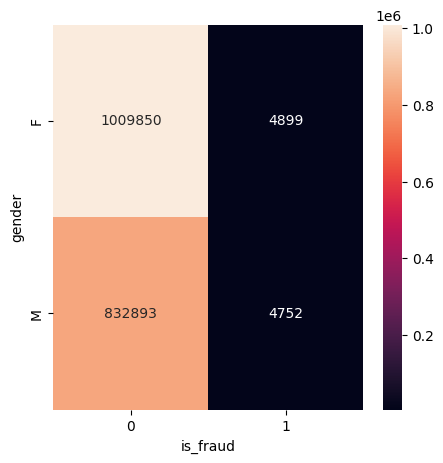

In [ ]:
crosstabs(all_data.select(['gender', 'is_fraud']).toPandas(), ['gender', 'is_fraud'], shape = (1, 1), figsize = (5, 5))

In [ ]:
num_jobs = customers.select('job').distinct().count()
print(f'Number of distinct jobs: {num_jobs}')

Number of distinct jobs: 497


## Chi-Square test

`Apparently, there is no association between the two categories, but we'll test with the Chi-Square test`

**Null Hypothesis (H0)**
The null hypothesis states that there is no association between gender and fraud. In other words, the distribution of fraud cases is independent of gender.

$H0$
:
There is no association between gender and fraud.

**Alternative Hypothesis (H1)**
The alternative hypothesis states that there is an association between gender and fraud. In other words, the distribution of fraud cases depends on gender.

$H1$
:
There is an association between gender and fraud.


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline


string_indexer = StringIndexer(inputCols = ['gender', 'job'], outputCols = ['gender_idx', 'job_idx'])
gender_assembler = VectorAssembler(inputCols = ['gender_idx'], outputCol = 'gender_vec')
job_assembler = VectorAssembler(inputCols = ['job_idx'], outputCol = 'job_vec')
all_data_vec = Pipeline(stages = [string_indexer, gender_assembler, job_assembler]).fit(all_data).transform(all_data)
all_data_vec.show()

+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+------------------+-------------------+--------+----+----------+-------+----------+-------+
|trans_date_trans_time|            merchant|      category|   amt|gender|state|    lat|     long|city_pop|                 job| unix_time|         merch_lat|         merch_long|is_fraud| age|gender_idx|job_idx|gender_vec|job_vec|
+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+------------------+-------------------+--------+----+----------+-------+----------+-------+
|  2019-01-01 01:56:49| fraud_Pacocha-Bauch|  shopping_pos|  8.34|     M|   NY|43.0622| -77.2218|    9565| Exhibition designer|1325383009|         42.624988|         -76.508987|       0|97.0|       1.0|    1.0|     [1.0]|  [1.0]|
|  2019-01-01 02:38:49|fraud_Strosin-Cru...|   grocery_pos|128.24|     M|   MT|4

In [ ]:
from pyspark.ml.stat import ChiSquareTest
genderchiSqResult = ChiSquareTest.test(all_data_vec, 'gender_vec', 'is_fraud')
genderchiSqResult.show()

+--------------------+----------------+-------------------+
|             pValues|degreesOfFreedom|         statistics|
+--------------------+----------------+-------------------+
|[1.77635683940025...|             [1]|[63.25402213730509]|
+--------------------+----------------+-------------------+



`Since the pValue is greater than 0.05, we cannot reject the null hypothesis, which means that there is no association between gender and fraud.`

In [ ]:
jobchiSqResult = ChiSquareTest.test(all_data_vec, 'job_vec', 'is_fraud')
jobchiSqResult.show()

+-------+----------------+--------------------+
|pValues|degreesOfFreedom|          statistics|
+-------+----------------+--------------------+
|  [0.0]|           [496]|[48073.228171839364]|
+-------+----------------+--------------------+



`Since the pValue is less than 0.05, we can reject the null hypothesis, which means that there is a potential association between job and fraud.`

# Transaction date and time

In [37]:
all_data = all_data.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))
all_data = all_data.drop('trans_date_trans_time')

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `trans_date_trans_time` cannot be resolved. Did you mean one of the following? [`trans_hour`, `unix_time`, `category`, `gender`, `is_fraud`].;
'Project [merchant#668, category#669, amt#670, gender#673, state#676, lat#678, long#679, city_pop#680, job#681, unix_time#684, merch_lat#685, merch_long#686, is_fraud#687, hour(to_timestamp('trans_date_trans_time, None, TimestampType, Some(Etc/UTC), false), Some(Etc/UTC)) AS trans_hour#1280, age#1248]
+- Project [merchant#668, category#669, amt#670, gender#673, state#676, lat#678, long#679, city_pop#680, job#681, unix_time#684, merch_lat#685, merch_long#686, is_fraud#687, trans_hour#1215, age#1248]
   +- Project [merchant#668, category#669, amt#670, gender#673, state#676, lat#678, long#679, city_pop#680, job#681, dob#682, unix_time#684, merch_lat#685, merch_long#686, is_fraud#687, trans_hour#1215, round((cast(datediff(current_date(Some(Etc/UTC)), dob#682) as double) / cast(365 as double)), 0) AS age#1248]
      +- Project [merchant#668, category#669, amt#670, gender#673, state#676, lat#678, long#679, city_pop#680, job#681, dob#682, unix_time#684, merch_lat#685, merch_long#686, is_fraud#687, trans_hour#1215]
         +- Project [trans_date_trans_time#666, merchant#668, category#669, amt#670, gender#673, state#676, lat#678, long#679, city_pop#680, job#681, dob#682, unix_time#684, merch_lat#685, merch_long#686, is_fraud#687, hour(to_timestamp(trans_date_trans_time#666, None, TimestampType, Some(Etc/UTC), false), Some(Etc/UTC)) AS trans_hour#1215]
            +- Deduplicate [unix_time#684, merch_lat#685, trans_date_trans_time#666, state#676, dob#682, job#681, city_pop#680, merch_long#686, amt#670, long#679, category#669, merchant#668, lat#678, is_fraud#687, gender#673]
               +- Project [trans_date_trans_time#666, merchant#668, category#669, amt#670, gender#673, state#676, lat#678, long#679, city_pop#680, job#681, dob#682, unix_time#684, merch_lat#685, merch_long#686, is_fraud#687]
                  +- Union false, false
                     :- Relation [_c0#665,trans_date_trans_time#666,cc_num#667L,merchant#668,category#669,amt#670,first#671,last#672,gender#673,street#674,city#675,state#676,zip#677,lat#678,long#679,city_pop#680,job#681,dob#682,trans_num#683,unix_time#684,merch_lat#685,merch_long#686,is_fraud#687] csv
                     +- Relation [_c0#728,trans_date_trans_time#729,cc_num#730L,merchant#731,category#732,amt#733,first#734,last#735,gender#736,street#737,city#738,state#739,zip#740,lat#741,long#742,city_pop#743,job#744,dob#745,trans_num#746,unix_time#747,merch_lat#748,merch_long#749,is_fraud#750] csv


In [ ]:
fig = histograms(all_data.select('trans_hour').toPandas(), x = ['trans_hour'], shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
counts = all_data.groupby(['trans_hour', 'is_fraud']).count().orderBy('trans_hour')
counts = counts.withColumnRenamed('count', 'counts')

In [ ]:
fig = target_histograms(all_data.select('trans_hour', 'is_fraud').toPandas(),
                  x = ['trans_hour'],
                  y = 'is_fraud',
                  shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

$$
P(x = \{0, ..., 23\}/y = \{0, 1\})
$$

In [ ]:
total_counts = counts.groupBy('is_fraud').agg(F.sum('counts').alias('total_counts')).collect()
total_counts_dict = {row['is_fraud']: row['total_counts'] for row in total_counts}

p_x_given_y = counts.withColumn('p_x_given_y',
                                F.col('counts') / F.when(F.col('is_fraud') == 1, total_counts_dict[1])
                                                      .otherwise(total_counts_dict[0])) \
                   .withColumn('class', F.when(F.col('is_fraud') == 1, F.lit('Fraud')).otherwise(F.lit('Not Fraud')))

In [ ]:
p_x_given_y = p_x_given_y.toPandas()

In [ ]:
p_x_given_y.head()

,trans_hour,is_fraud,counts,p_x_given_y,class
0,0,0,59832,0.032469,Not Fraud
1,0,1,823,0.085276,Fraud
2,1,0,60503,0.032833,Not Fraud
3,1,1,827,0.085691,Fraud
4,2,1,793,0.082168,Fraud


In [ ]:
fig = px.line(p_x_given_y,
              x = 'trans_hour',
              y = 'p_x_given_y',
              labels = {'x': 'Hour of the day', 'y': 'Probability'},
              title = 'Probability Distribution',
              line_shape = 'linear',
              color = 'class')


fig.show()

`It seems that frauds are likely to happen at night after 21 and before the morning.`

In [ ]:
import scipy.stats as stats

In [ ]:
hours_fraud = all_data.select('trans_hour', 'is_fraud').toPandas()
stats.mannwhitneyu(hours_fraud[hours_fraud['is_fraud'] == 1]['trans_hour'], hours_fraud[hours_fraud['is_fraud'] == 0]['trans_hour'])

MannwhitneyuResult(statistic=10414082581.5, pvalue=7.295924268803254e-186)

In [ ]:
size = len(hours_fraud[hours_fraud['is_fraud'] == 1])
stats.wilcoxon(hours_fraud[hours_fraud['is_fraud'] == 1]['trans_hour'], hours_fraud[hours_fraud['is_fraud'] == 0]['trans_hour'].sample(size))

WilcoxonResult(statistic=18613858.0, pvalue=4.4273939504363136e-26)

`From these 2 tests, we can confirm our assumptions that there is an association between frauds and transaction hours`

# Numerical columns

In [38]:
numerical_data = all_data.select('amt', 'age', 'unix_time', F.log('amt'), 'trans_hour', 'is_fraud') \
                          .withColumnRenamed(existing = 'ln(amt)', new = 'ln_amt') \
                          .toPandas()
numerical_data.head()

,amt,age,unix_time,ln_amt,trans_hour,is_fraud
0,8.34,97.0,1325383009,2.121063,1,0
1,128.24,61.0,1325385529,4.853904,2,0
2,68.07,41.0,1325390805,4.220537,4,0
3,3.68,66.0,1325403046,1.302913,7,0
4,134.75,98.0,1325404958,4.903421,8,0


## Histograms

In [ ]:
fig = histograms(numerical_data, x = ['age', 'amt'], shape = (1, 2))

Output hidden; open in https://colab.research.google.com to view.

`Amount column contains outliers and write skewed`




In [ ]:
fig = histograms(numerical_data, x = ['unix_time'], shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

<Axes: xlabel='ln_amt', ylabel='Density'>

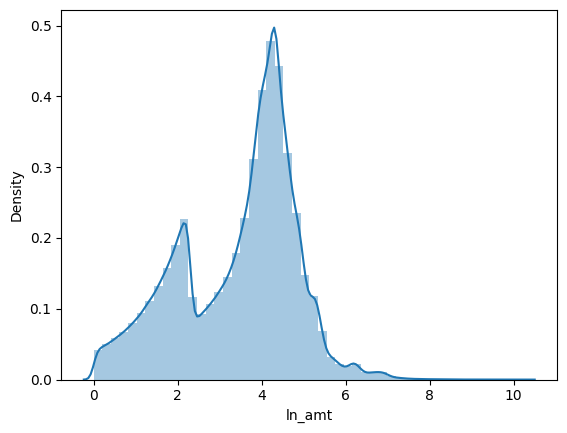

In [ ]:
sns.distplot(numerical_data['ln_amt'], kde = True)

## Distribution based on fraud

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

In [ ]:
fig = target_histograms(numerical_data, x = ['age', 'amt'], y = 'is_fraud', shape = (1, 2))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = target_histograms(numerical_data, x = ['unix_time'], y = 'is_fraud', shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

<Axes: xlabel='ln_amt', ylabel='Density'>

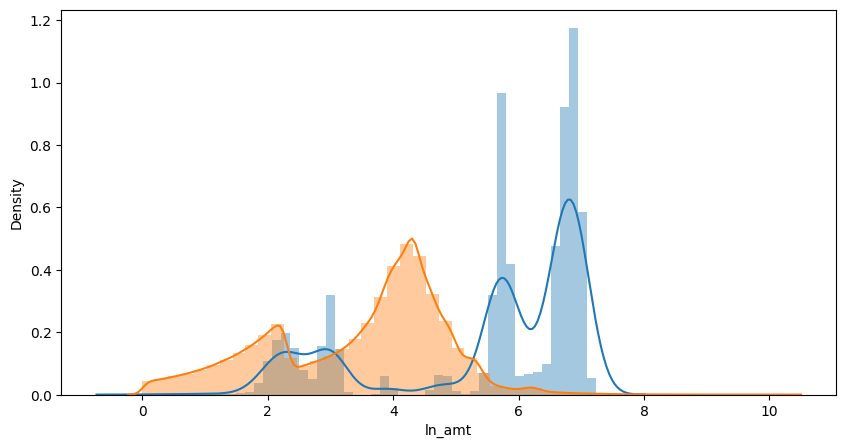

In [ ]:
plt.figure(figsize = (10, 5))
sns.distplot(numerical_data[numerical_data['is_fraud'] == 1]['ln_amt'], kde = True, label = 'is_fraud')
sns.distplot(numerical_data[numerical_data['is_fraud'] == 0]['ln_amt'], kde = True, label = 'no_fraud')

`We can see a difference now between fraudulent and non fraudulent transaction`

## Hypothesis testing

In [ ]:
import scipy.stats as stats

fraud_amt = numerical_data[numerical_data['is_fraud'] == 1]['ln_amt']
non_fraud_amt = numerical_data[numerical_data['is_fraud'] == 0]['ln_amt'].sample(len(fraud_amt))

assert len(fraud_amt) == len(non_fraud_amt)
stats.mannwhitneyu(non_fraud_amt, fraud_amt)

MannwhitneyuResult(statistic=15566863.0, pvalue=0.0)

`After transforming the amount column, we can see that there is a difference between fraudulent and non fraudulent transactions`

In [ ]:
import itertools
import plotly.express as px
from plotly.subplots import make_subplots
from tqdm import tqdm

def scatter_plots(data, x: list, y: str, shape: tuple):
    combinations = list(itertools.combinations(x, 2))
    assert len(combinations) <= shape[0] * shape[1], "Number of combinations exceeds the grid shape"

    fig = make_subplots(rows=shape[0], cols=shape[1], subplot_titles=[f"{comb[0]} vs {comb[1]}" for comb in combinations])

    legend_added = {cat: False for cat in data[y].unique()}

    for i, comb in enumerate(tqdm(combinations, desc=f'Plotting scatter plots grouped by {y} column')):
        scatter_fig = px.scatter(data, x=comb[0], y=comb[1], color=y)

        for trace in scatter_fig.data:
            # Handle potential empty trace names
            trace_name = trace.name if trace.name else 'Unknown'
            trace.showlegend = not legend_added.get(trace_name, False)  # Show legend only for the first occurrence
            legend_added[trace_name] = True

        fig.add_traces(scatter_fig.data, rows=(i // shape[1] + 1), cols=(i % shape[1] + 1))

    fig.update_layout(showlegend=True)
    fig.show()
    return fig

## Scatter plots

In [ ]:
fig = scatter_plots(numerical_data, x = ['age', 'amt'], y = 'is_fraud', shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

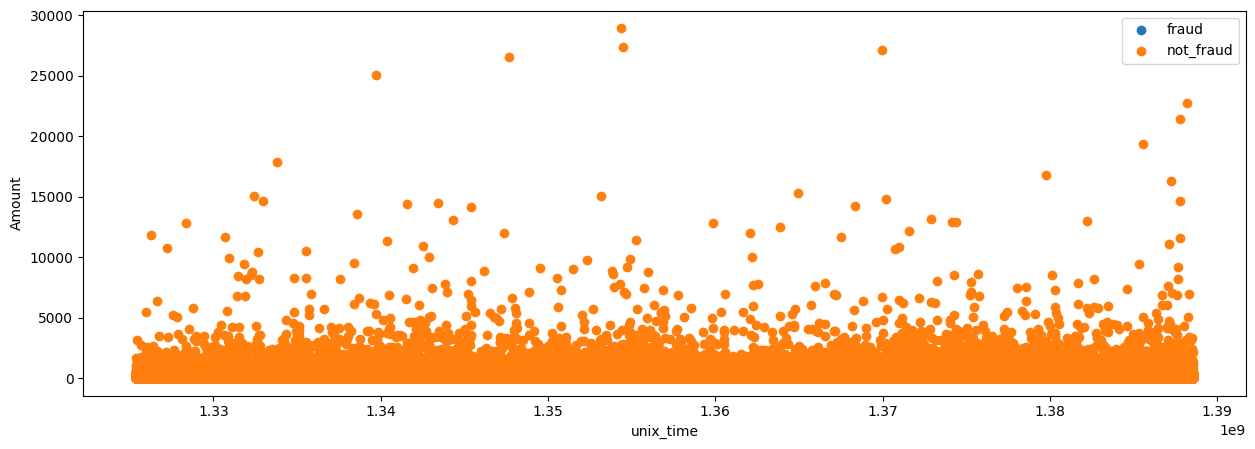

In [ ]:
plt.figure(figsize = (15, 5))
plt.scatter(numerical_data[numerical_data['is_fraud'] == 1]['unix_time'],
            numerical_data[numerical_data['is_fraud'] == 1]['amt'],
            label = 'fraud')
plt.scatter(numerical_data[numerical_data['is_fraud'] == 0]['unix_time'],
            numerical_data[numerical_data['is_fraud'] == 0]['amt'],
            label = 'not_fraud')
plt.xlabel('unix_time')
plt.ylabel('Amount')
plt.legend()
plt.show()

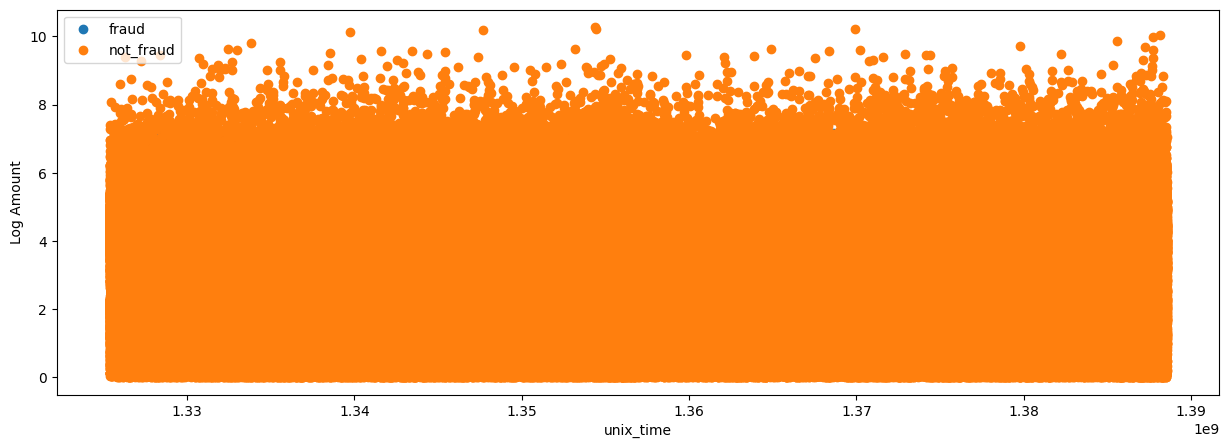

In [ ]:
plt.figure(figsize = (15, 5))
plt.scatter(numerical_data[numerical_data['is_fraud'] == 1]['unix_time'],
            numerical_data[numerical_data['is_fraud'] == 1]['ln_amt'],
            label = 'fraud')
plt.scatter(numerical_data[numerical_data['is_fraud'] == 0]['unix_time'],
            numerical_data[numerical_data['is_fraud'] == 0]['ln_amt'],
            label = 'not_fraud')
plt.xlabel('unix_time')
plt.ylabel('Log Amount')
plt.legend()
plt.show()

## Pairplot

In [ ]:
sns.pairplot(numerical_data, hue = 'is_fraud')

KeyboardInterrupt: 

# City population

In [ ]:
city_pop_data = all_data.select('city_pop', 'is_fraud').toPandas()

In [ ]:
fig = histograms(city_pop_data, x = ['city_pop'], shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = target_histograms(city_pop_data, x = ['city_pop'], y = 'is_fraud', shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
city_pop_data['ln(city_pop)'] = np.log(city_pop_data['city_pop'])
city_pop_data['sqrt(city_pop)'] = np.sqrt(city_pop_data['city_pop'])

<Axes: xlabel='sqrt(city_pop)', ylabel='Density'>

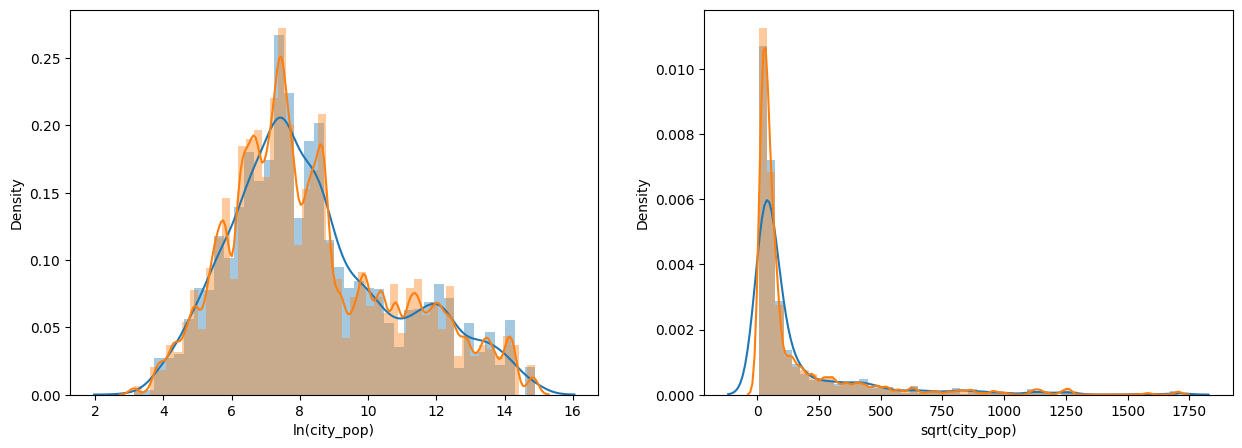

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
sns.distplot(city_pop_data[city_pop_data['is_fraud'] == 1]['ln(city_pop)'], kde = True, ax = axs[0], label = 'fraud')
sns.distplot(city_pop_data[city_pop_data['is_fraud'] == 0]['ln(city_pop)'], kde = True, ax = axs[0], label = 'not_fraud')

sns.distplot(city_pop_data[city_pop_data['is_fraud'] == 1]['sqrt(city_pop)'], kde = True, ax = axs[1], label = 'fraud')
sns.distplot(city_pop_data[city_pop_data['is_fraud'] == 0]['sqrt(city_pop)'], kde = True, ax = axs[1], label = 'not_fraud')

`No difference between both`

# Category column

In [ ]:
category_data = all_data.select('category', 'is_fraud').toPandas()

In [ ]:
fig = barplots(category_data, columns = ['category'], shape = (1, 1))

Plotting barplots: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


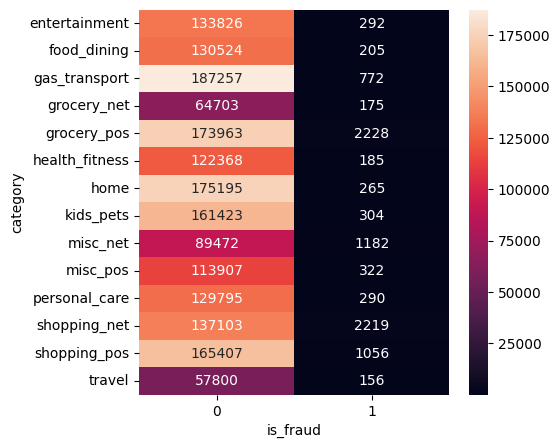

In [ ]:
crosstabs(category_data, ['category', 'is_fraud'], shape = (1, 1), figsize = (5, 5))

In [ ]:
string_indexer = StringIndexer(inputCols = ['category'], outputCols = ['category_idx'])
vector_assembler = VectorAssembler(inputCols = ["category_idx"], outputCol = "category_vec")
all_data_vec = Pipeline(stages = [string_indexer, vector_assembler]).fit(all_data_vec).transform(all_data_vec)
all_data_vec.show()

+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+
|trans_date_trans_time|            merchant|      category|   amt|gender|state|    lat|     long|city_pop|                 job|       dob| unix_time|         merch_lat|         merch_long|is_fraud| age|gender_idx|gender_vec|category_idx|category_vec|
+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+
|  2019-01-01 01:56:49| fraud_Pacocha-Bauch|  shopping_pos|  8.34|     M|   NY|43.0622| -77.2218|    9565| Exhibition designer|1927-12-11|1325383009|         42.624988|         -76.508987|       0|97.0|       1.0|     [1.0]|         3.0|       [3.

In [ ]:
chiSqResult = ChiSquareTest.test(all_data_vec, 'category_vec', 'is_fraud')
chiSqResult.show()

+-------+----------------+-------------------+
|pValues|degreesOfFreedom|         statistics|
+-------+----------------+-------------------+
|  [0.0]|            [13]|[8329.139945520074]|
+-------+----------------+-------------------+



`We have a pValues less than 0.05, so we can assume that frauds are related to transaction categories`

``

# State column

In [ ]:
state_data = all_data.select('state', 'is_fraud').toPandas()

In [ ]:
fig = barplots(state_data, columns = ['state'], shape = (1, 1))

Plotting barplots: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


In [ ]:
string_indexer = StringIndexer(inputCols = ['state'], outputCols = ['state_idx'])
vector_assembler = VectorAssembler(inputCols = ["state_idx"], outputCol = "state_vec")
all_data_vec = Pipeline(stages = [string_indexer, vector_assembler]).fit(all_data_vec).transform(all_data_vec)
all_data_vec.show()

+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+---------+---------+
|trans_date_trans_time|            merchant|      category|   amt|gender|state|    lat|     long|city_pop|                 job|       dob| unix_time|         merch_lat|         merch_long|is_fraud| age|gender_idx|gender_vec|category_idx|category_vec|state_idx|state_vec|
+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+---------+---------+
|  2019-01-01 01:56:49| fraud_Pacocha-Bauch|  shopping_pos|  8.34|     M|   NY|43.0622| -77.2218|    9565| Exhibition designer|1927-12-11|1325383009|         42.624988|         -76.508987

In [ ]:
chiSqResult = ChiSquareTest.test(all_data_vec, 'state_vec', 'is_fraud')
chiSqResult.show()

+-------+----------------+--------------------+
|pValues|degreesOfFreedom|          statistics|
+-------+----------------+--------------------+
|  [0.0]|            [50]|[2022.1228324519125]|
+-------+----------------+--------------------+



# Long and lat

In [ ]:
coordinates_data = all_data.select('long', 'lat', 'merch_long', 'merch_lat', 'is_fraud').toPandas()

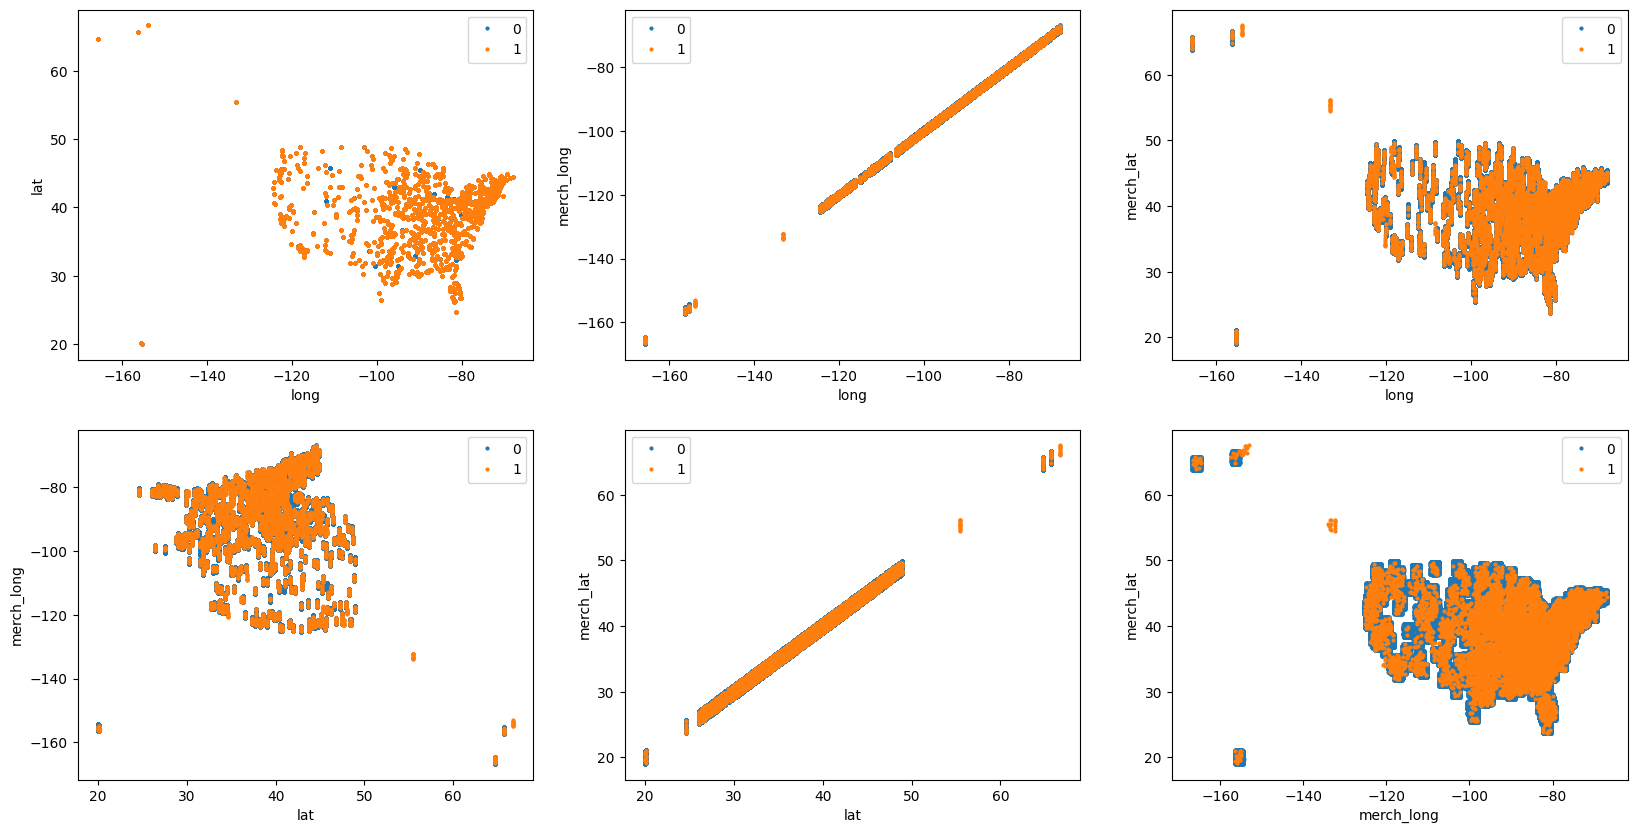

In [ ]:
scatter_plots(coordinates_data, x = ['long', 'lat', 'merch_long', 'merch_lat'], y = 'is_fraud', shape = (2, 3), figsize = (20, 10))

`Not a big difference between fraudulent and non fraudulent transactions`

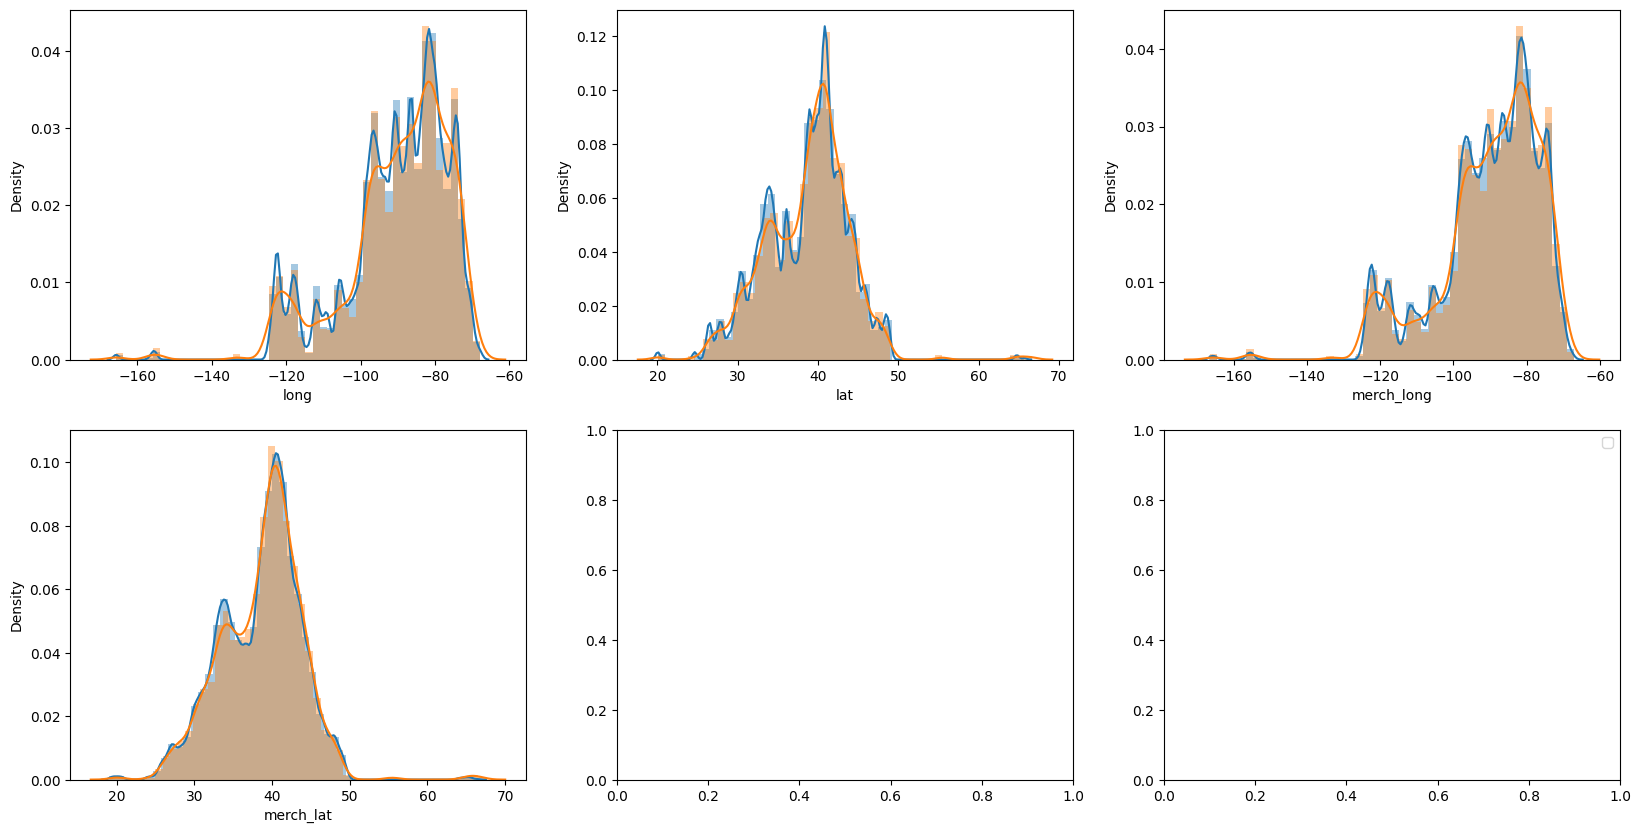

In [ ]:
target_histograms(
    coordinates_data,
    x = ['long', 'lat', 'merch_long', 'merch_lat'],
    y = 'is_fraud',
    shape = (2, 3),
    figsize = (20, 10)
)

# Merchant

In [ ]:
all_data.select('merchant').distinct().count()

693

In [ ]:
string_indexer = StringIndexer(inputCols = ['merchant'], outputCols = ['merchant_idx'])
merchant_assembler = VectorAssembler(inputCols = ['merchant_idx'], outputCol = 'merchant_vec')
all_data_vec = Pipeline(stages = [string_indexer, merchant_assembler]).fit(all_data).transform(all_data)
all_data_vec.show()

+--------------------+-------------+------+------+-----+-------+------------------+--------+--------------------+----------+------------------+------------------+--------+----+----------+------------+------------+
|            merchant|     category|   amt|gender|state|    lat|              long|city_pop|                 job| unix_time|         merch_lat|        merch_long|is_fraud| age|trans_hour|merchant_idx|merchant_vec|
+--------------------+-------------+------+------+-----+-------+------------------+--------+--------------------+----------+------------------+------------------+--------+----+----------+------------+------------+
|fraud_Rippin, Kub...|     misc_net|  4.97|     F|   NC|36.0788|          -81.1781|    3495|Psychologist, cou...|1325376018|         36.011293|        -82.048315|       0|36.0|         0|       584.0|     [584.0]|
|fraud_Heller, Gut...|  grocery_pos|107.23|     F|   WA|48.8878|         -118.2105|     149|Special education...|1325376044|49.159046999999994| 

In [ ]:
merchantchiSqResult = ChiSquareTest.test(all_data_vec, 'merchant_vec', 'is_fraud')
merchantchiSqResult.show()

+-------+----------------+-------------------+
|pValues|degreesOfFreedom|         statistics|
+-------+----------------+-------------------+
|  [0.0]|           [692]|[8761.093873779399]|
+-------+----------------+-------------------+



# Saving data

In [ ]:
train = train.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))
test = test.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))

In [ ]:
train = train.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))
test = test.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))

In [ ]:
train = train.select('merchant', 'category', 'amt', 'state', 'job', 'is_fraud', 'age', 'trans_hour')
test = test.select('merchant', 'category', 'amt', 'state', 'job', 'is_fraud', 'age', 'trans_hour')

In [ ]:
output_path = "input"

train.write.parquet(os.path.join(output_path, 'finalTrain.parquet'))
test.write.parquet(os.path.join(output_path, 'finalTest.parquet'))

In [ ]:
sc.stop()